In [1]:
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, Dropout, Flatten, MaxPooling2D
from keras.models import Model

In [2]:
def vgg_face(input_shape):
    X_input = Input(input_shape)
    X = ZeroPadding2D((1,1))(X_input)
    X = Conv2D(64,(3,3), activation = 'relu')(X)
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(64,(3,3), activation = 'relu')(X)
    X = MaxPooling2D((2,2), strides = (2,2))(X)

    
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(128,(3,3), activation = 'relu')(X)
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(128,(3,3), activation ='relu')(X)
    X = MaxPooling2D((2,2), strides = (2,2))(X)

    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(256,(3,3),activation ='relu')(X)
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(256,(3,3),activation ='relu')(X)
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(256,(3,3),activation ='relu')(X)
    X = MaxPooling2D((2,2), strides = (2,2))(X)

    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(512,(3,3), activation = 'relu')(X)
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(512,(3,3), activation = 'relu')(X)
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(512,(3,3), activation = 'relu')(X)
    X = MaxPooling2D((2,2), strides = (2,2))(X)

    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(512,(3,3), activation = 'relu')(X)
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(512,(3,3), activation = 'relu')(X)
    X = ZeroPadding2D((1,1))(X)
    X = Conv2D(512,(3,3), activation = 'relu')(X)
    X = MaxPooling2D((2,2), strides = (2,2))(X)
    
    X = Conv2D(4096,(7,7),activation = 'relu')(X)
    X = Dropout(0.5)(X)
    X = Conv2D(4096,(1,1), activation = 'relu')(X)
    X = Dropout(0.5)(X)
    X = Conv2D(2622,(1,1))(X)
    X = Flatten()(X)
    X = Activation('softmax')(X)
    
    model = Model(inputs = X_input,outputs = X)

    return model

In [3]:
Vgg_Face = vgg_face(input_shape = (224,224,3))

Load weights: [download here](https://drive.google.com/uc?id=1CPSeum3HpopfomUEK1gybeuIVoeJT_Eo)

In [4]:
Vgg_Face.load_weights('vgg_face_weights.h5')

In [5]:
vgg_face = Model(inputs=Vgg_Face.layers[0].input
, outputs=Vgg_Face.layers[-2].output)

In [6]:
from keras.preprocessing import image
import numpy as np

def img_to_encoding(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img/255.
    embedding = vgg_face.predict(img)[0,:]
    return embedding

def d1(source_representation, test_representation):
    euclidean_distance = source_representation - test_representation
    euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
    euclidean_distance = np.sqrt(euclidean_distance)
    return euclidean_distance

In [7]:
database = {}
database["bo_thien"] = img_to_encoding("images/bo_thien.jpg")
database["me_hien"] = img_to_encoding("images/me_hien.jpg")
database["thien_chan"] = img_to_encoding("images/thien_chan.jpg")
database["ba_thuan"] = img_to_encoding("images/ba_thuan.jpg")
database["o_tham"] = img_to_encoding("images/o_tham.jpg")

In [8]:
def verify(image_path, identity, database):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
    image_path -- path to an image
    identity -- string, name of the person you'd like to verify the identity. Has to be an employee who works in the office.
    database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
    
    Returns:
    dist -- distance between the image_path and the image of "identity" in the database.
    door_open -- True, if the door should open. False otherwise.
    """
    encoding = img_to_encoding(image_path)
    dist = d1(encoding, database[identity])
    if dist < 0.5:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False      
    return dist, door_open

It's not me_hien, please go away


(0.5436377, False)

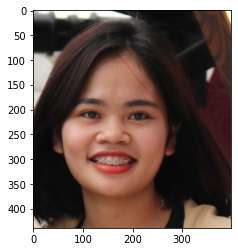

In [9]:
from matplotlib.pyplot import imshow

img_path = 'images/test3.jpg'
img = image.load_img(img_path)
imshow(img)
verify(img_path, "me_hien", database)

It's thien_chan, welcome in!


(0.4072143, True)

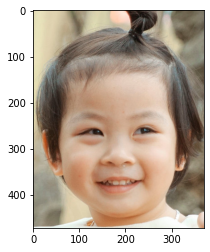

In [10]:
img_path = 'images/test7.jpg'
img = image.load_img(img_path)
imshow(img)
verify(img_path, "thien_chan", database)

It's not ba_thuan, please go away


(0.77162886, False)

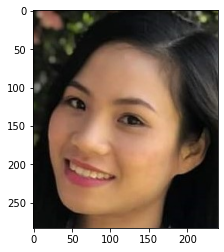

In [11]:
img_path = 'images/o_tham.jpg'
img = image.load_img(img_path)
imshow(img)
verify(img_path, "ba_thuan", database)

In [12]:
def who_is_it(image_path, database):
    """
    Arguments:
    image_path -- path to an image
    database -- database containing image encodings along with the name of the person on the image
    model -- your Inception model instance in Keras
    
    Returns:
    min_dist -- the minimum distance between image_path encoding and the encodings from the database
    identity -- string, the name prediction for the person on image_path
    """
    encoding = img_to_encoding(image_path) 
    min_dist = 100
    for (name, db_enc) in database.items():
        dist = d1(encoding, database[name])
        if dist < min_dist:
            min_dist = dist
            identity = name

    if min_dist > 0.5:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

it's thien_chan, the distance is 0.45408607


(0.45408607, 'thien_chan')

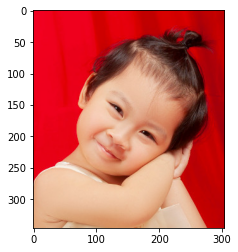

In [13]:
img_path = 'images/test5.jpg'
img = image.load_img(img_path)
imshow(img)
who_is_it(img_path, database)

Not in the database.


(0.574559, 'me_hien')

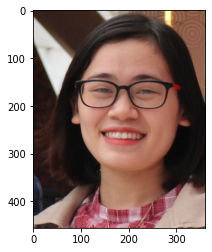

In [14]:
img_path = 'images/test4.jpg'
img = image.load_img(img_path)
imshow(img)
who_is_it(img_path, database)